# TestingEvaluate_Model1

# Libraries

In [3]:
# directory set up 
import os,sys,inspect
current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir) 

# data attainment
import pandas as pd

# mathematical
import tensorflow as tf
import numpy as np

# preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from Extra_Work.PythonFiles.preprocessing import scale_data

# modelling
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import LayerNormalization, BatchNormalization, Dense, Dropout

# evaluation
from Extra_Work.PythonFiles.modelling import evaluate_models
from Extra_Work.PythonFiles.modelling import FeedForward

# plotting
import matplotlib.pyplot as plt

# setting global seeds
tf.random.set_seed(1)
np.random.seed(1)

# Data

In [4]:
# load data

df = pd.read_csv('../Data/dataset1.csv')

X, scalers = scale_data(df[df.columns[:-1]], mode = 'robust')
#X['Spring constant (N per m)'] = 0
#X['Ball radius (mm)'] = 0

y = df[df.columns[-1]]

y_binary = to_categorical(y)

data = train_test_split(
    X,y_binary, test_size = 0.8, random_state = 23
)



In [5]:
X.head(5)

,Arm length (m),Ball weight (kg),Ball radius (mm),Air temperature (deg C),Spring constant (N per m),Device weight (kg)
0,-0.043861,0.229213,-1.108981,-0.142857,1.381838,0.092010
1,-0.384055,1.556123,1.830060,1.000000,0.418311,0.413477
2,1.428080,1.044860,0.110074,-1.142857,1.264973,0.196250
3,-0.622975,1.113682,-0.428175,0.142857,-0.910192,0.084416
4,-1.024151,0.608240,-0.006623,-1.142857,-0.863281,-0.149819


In [6]:
y_binary

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# Data Exploration

# Model Cell

In [122]:
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.activations import elu, relu 
from tensorflow.keras.layers import Activation

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import PReLU
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.initializers import glorot_normal
from tensorflow.keras.constraints import MinMaxNorm

# add automation to this
def uncompiled_model():
    inputs = Input(shape=(6,), name='Data')
    # my model
   # x = Dense(4, activation = 'relu',bias_initializer=Constant(0.7))(inputs)
   # x = BatchNormalization()(x)
     #   outputs = Dense(2, activation='softmax', name='TargetHit')(x)



    #x = Dropout(0.2)(x)

    # try adding weight constraints to model
    #x = Dense(8, activation='relu')(x)
    #x = BatchNormalization()(x)


    # and make sure that epochs = 250
    # update, best is 16,8,16 with batch = 50, epochs = 250
    # also 32,16,32



    # chris model
    #x = Dense(3, activation='linear')(inputs)
    #outputs = Dense(2, activation = 'sigmoid')(x)
    
    # try by adding a very small bias of 0.1 to the relu's
    # kyriacos model
    #x = Dense(8, activation = 'softmax', bias_initializer = Constant(0.1))(inputs)
    #x = BatchNormalization()(x)
    #x = Dense(4, activation = 'softmax')(x)
    #x = BatchNormalization()(x)


    #x = Dense(8, activation = 'softmax',)(x)
    #x = BatchNormalization()(x)
    #x_1 = Dense(4, activation = 'softmax', bias_initializer = Constant(0.5))(inputs)
    #x_2 = Dense(4, activation = 'relu', bias_initializer = Constant(0.1))(inputs)
    #x_1 = BatchNormalization()(x_1)
    #x_2 = BatchNormalization()(x_2)
    #x = concatenate([x_1, x_2]) 
    
    x = Dense(4,
              activation = 'relu',
              kernel_constraint=MinMaxNorm(
                  min_value=0.3, max_value=1.0))(inputs)
    x = BatchNormalization()(x)
    outputs = Dense(2, activation = 'softmax')(x)
    
    # try splitting this into two layer things
    model = Model(inputs=inputs, outputs=outputs)
    return model


def compile_model():
    model = uncompiled_model()
    model.compile(
        #optimizer=Adam(learning_rate=0.01), # next step, add custom optimizers and modify learning 
        # rates. Adam yelds the best values
        optimizer = Adam(learning_rate = 0.001),
        #loss="binary_crossentropy", # binary_crossentropy
        loss = 'binary_crossentropy',
        metrics=["accuracy",
                 "binary_accuracy",
                 "binary_crossentropy",
                 "categorical_accuracy"
                 ],
    )
    return model
    

# Test Model

In [43]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience = 15, mode = 'max',monitor = 'val_accuracy')

from sklearn.model_selection import KFold
from time import time
def cross_validate(K = 5, **kwargs):
    scores = []
    histories = []
    X = np.concatenate((data[0], data[1]), axis = 0)
    y = np.concatenate((data[2], data[3]), axis = 0)
    for train, test in KFold(n_splits=K, shuffle=True).split(X,y):
        model = compile_model()
        start = time()
        histories.append(model.fit(X[train], y[train],
                                   validation_data = (X[test],y[test]),
                                   **kwargs).history)
        print(time() - start)
        scores.append(model.evaluate(X[test], y[test], verbose = 0))
    print("average loss: ", np.asarray(scores)[:,0].mean())
    print("average accuracy: ", np.asarray(scores)[:,1].mean()) # make sure that accuracy is the first metric in compile
    print(model.summary())
    return scores, histories

def plot_histories(histories, metrics = ['loss', 'accuracy','val_accuracy','val_loss']):
    fig, axes = plt.subplots(nrows = (len(metrics) - 1) // 2 + 1, ncols = 2, figsize = (16,16))
    axes = axes.reshape((len(metrics) - 1) // 2 + 1, 2)
    for i,metric in enumerate(metrics):
        for history in histories:
            axes[(i+2)//2 - 1, 1 - (i+1)%2].plot(history[metric])
        plt.legend([i for i in range(len(histories))])
        


In [123]:
scores, histories = cross_validate(K = 5, 
                                   epochs = 100,
                                   verbose = 0,
                                   batch_size = 50,
                                   shuffle = True,
                                   callbacks = [early_stopping])
    
#validation_split = 0.1, callbacks = [early_stopping]) #)
print(scores)

10.552150964736938
3.1409637928009033
2.4906160831451416
3.387238025665283
2.964756965637207
average loss:  0.2211429387331009
average accuracy:  0.9004999995231628
Model: "functional_351"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Data (InputLayer)            [(None, 6)]               0         
_________________________________________________________________
dense_381 (Dense)            (None, 4)                 28        
_________________________________________________________________
batch_normalization_201 (Bat (None, 4)                 16        
_________________________________________________________________
dense_382 (Dense)            (None, 2)                 10        
Total params: 54
Trainable params: 46
Non-trainable params: 8
_________________________________________________________________
None
[[0.24220240116119385, 0.8899999856948853, 0.8899999856948853, 0.24220240116119385, 

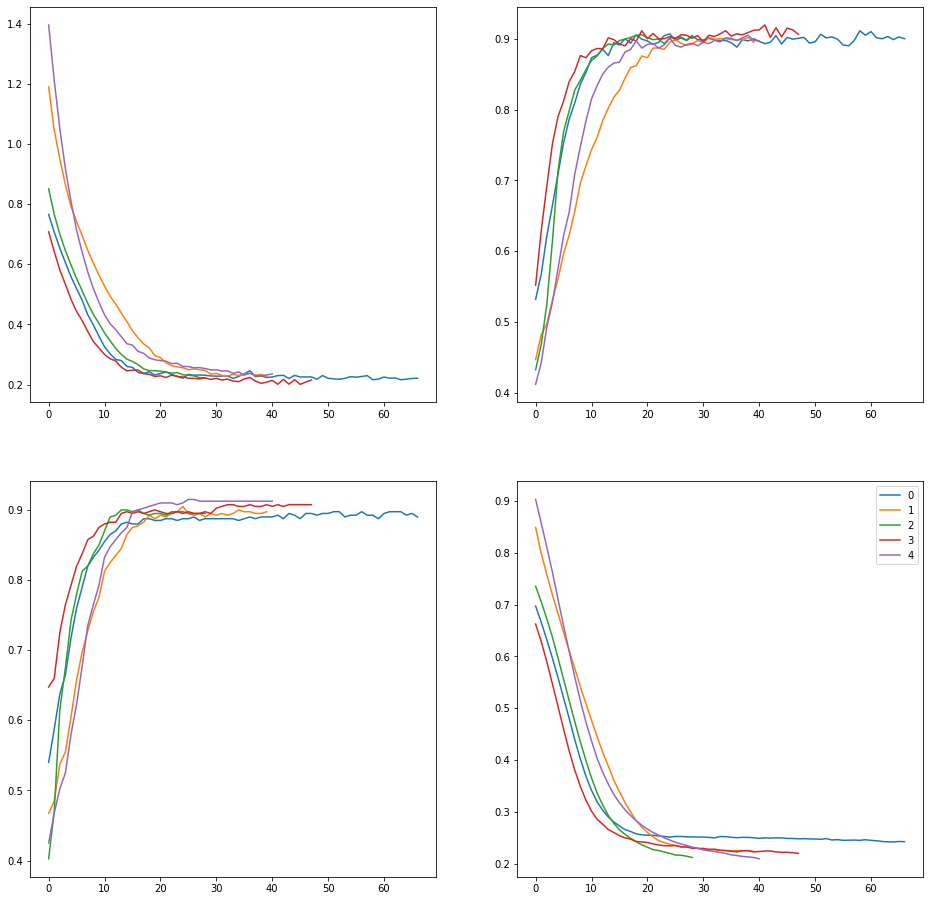

In [124]:
plot_histories(histories)

# Adi's method

In [26]:
# testing with validation split
model = compile_model()
start = time()
history = model.fit(X,y_binary,
                    shuffle = True, validation_split = 0.2,
                    epochs = 100, verbose = 0, batch_size = 32)
model.summary()

Model: "functional_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Data (InputLayer)            [(None, 6)]               0         
_________________________________________________________________
dense_42 (Dense)             (None, 4)                 28        
_________________________________________________________________
batch_normalization_17 (Batc (None, 4)                 16        
_________________________________________________________________
dense_43 (Dense)             (None, 4)                 20        
_________________________________________________________________
TargetHit (Dense)            (None, 2)                 10        
Total params: 74
Trainable params: 66
Non-trainable params: 8
_________________________________________________________________


63/63 [==============================] - 0s 2ms/step - loss: 0.0839 - accuracy: 0.9195 - binary_accuracy: 0.9193 - binary_crossentropy: 0.4227 - categorical_accuracy: 0.9195


[0.08389686048030853,
 0.9194999933242798,
 0.9192500114440918,
 0.42274174094200134,
 0.9194999933242798]

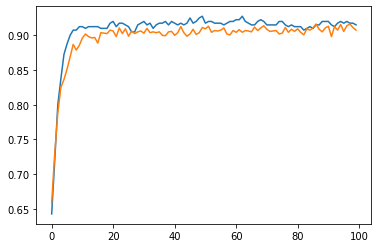

In [27]:
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
model.evaluate(X,y_binary)

In [12]:
instance.evaluate(epochs = 100, verbose = 0)


100/100 [==============================] - 0s 1ms/step - loss: 0.4429 - accuracy: 0.8059 - binary_accuracy: 0.8067 - binary_crossentropy: 0.4429 - categorical_accuracy: 0.8059


In [13]:
feedforward.print_params(-3)

[[0.442889928817749, 0.8059375286102295, 0.8067187666893005, 0.442889928817749, 3.5885000228881836, 482]]


In [14]:
#feedforward.plot_model()

In [15]:
#model = feedforward.get_model()
#yhat = model.predict(X_test)
#yhat = yhat[:,1]
#yhat[yhat > 0.5] = 1
#yhat[yhat <=0.5] = 0

In [16]:
#(yhat == y_test[:,1]).sum()/len(yhat)

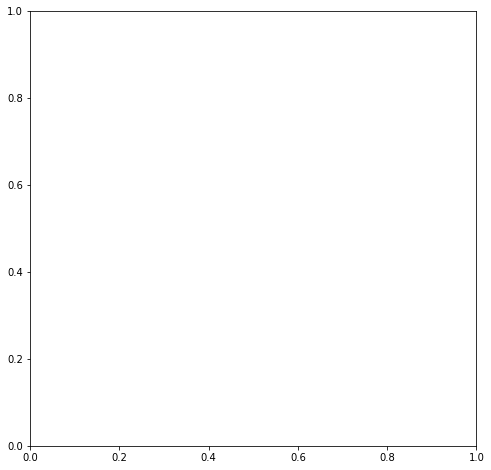

In [17]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (8,8))
plt.show()

2
{'figsize': (8, 8)}


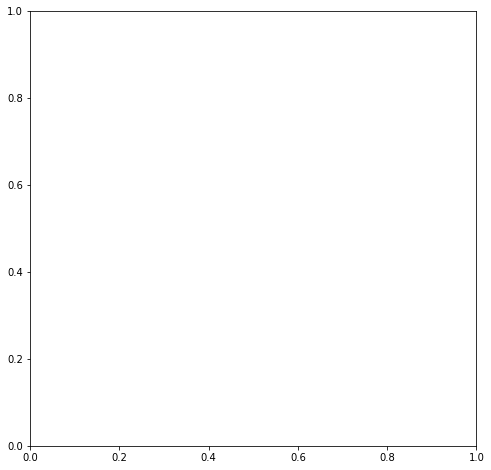

In [18]:
def function(*args, K = 5,**kwargs):
    print(args) if not args else print(args[0])
    print(kwargs)
    fig, ax = plt.subplots(**kwargs)
    plt.show()
    
function(2,figsize = (8,8))

https://dbader.org/blog/meaning-of-underscores-in-python

https://keras.io/api/layers/initializers/

https://stats.stackexchange.com/questions/330559/why-is-tanh-almost-always-better-than-sigmoid-as-an-activation-function

https://keras.io/api/losses/probabilistic_losses/#sparsecategoricalcrossentropy-class

https://ruder.io/optimizing-gradient-descent/

https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html

https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff

https://github.com/keras-team/keras/pull/9965

https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

https://stackoverflow.com/questions/51841506/data-standardization-vs-normalization-vs-robust-scaler

https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/

https://www.kdnuggets.com/2019/12/5-techniques-prevent-overfitting-neural-networks.html


https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd


https://www.quora.com/What-is-the-importance-of-the-validation-split-variable-in-Keras



In [93]:
# idea: run the model for different values and parameters and then use regression / calssification to find the best ones

# apparently having a small middle layer is good?

In [5]:
feedforward = FeedForward()


In [6]:
model = compile_model()
instance = evaluate_models(
    uncompiled_model(), compiler, *data
)

scores, histories = instance.cross_validate(epochs = 100, verbose = 0)


25/25 [==============================] - 0s 1ms/step - loss: 0.4103 - accuracy: 0.8325 - binary_accuracy: 0.8319 - binary_crossentropy: 0.4103 - categorical_accuracy: 0.8325
average loss:  0.44904146790504457
average accuracy:  0.8014999985694885


[0.74250001 0.80124998 0.80500001 0.82625002 0.83249998]


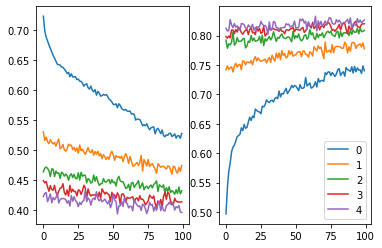

In [7]:
instance.plot_histories(histories)
print(np.asarray(scores)[:,1])